# Exercise 3
All previous instructions hold. In addition, if you are using GPU, you must check that your code also runs on a CPU. 

**Make sure you use the best practices you learned in class**.

In [40]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Convolutional Neural Network - Classifiying CIFAR-10 (40 points)

So far we had to manually implement both the forward and backward passes of our neural network. Manually implementing the backward pass is not a big deal for a small two-layer network, but can quickly get very messy for large complex networks.

Thankfully, we can use **automatic differentiation** to automate the computation of backward passes in neural networks. The autograd package in PyTorch provides exactly this functionality. When using autograd, the forward pass of your network will define a computational graph. Nodes in the graph will be Tensors,
and edges will be functions that produce output Tensors from input Tensors. Backpropagating through this graph then allows you to easily compute gradients.

If we want to compute gradients with respect to some Tensor, then we set `requires_grad=True` when constructing that Tensor. Any PyTorch operations on that Tensor will cause a computational graph to be constructed, allowing us to later perform backpropagation through the graph. If `x` is a Tensor with `requires_grad=True`, then after backpropagation `x.grad` will be another Tensor holding the gradient of `x`.

Sometimes you may wish to prevent PyTorch from building computational graphs when performing certain operations on Tensors with `requires_grad=True`; for example, we usually don't want to backpropagate through the weight update steps when evaluating a neural network. In such scenarios we can use the `torch.no_grad()` context manager to prevent the construction of a computational graph.

In this exercise, you will accomplish the following:
1. Train a convolutional network using PyTorch.
2. Evaluate your model using a confusion matrix.
3. Solve the localization task using regression.

### Data Preprocessing

In [41]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Image shape:  torch.Size([3, 32, 32])
       cat      truck       deer        dog


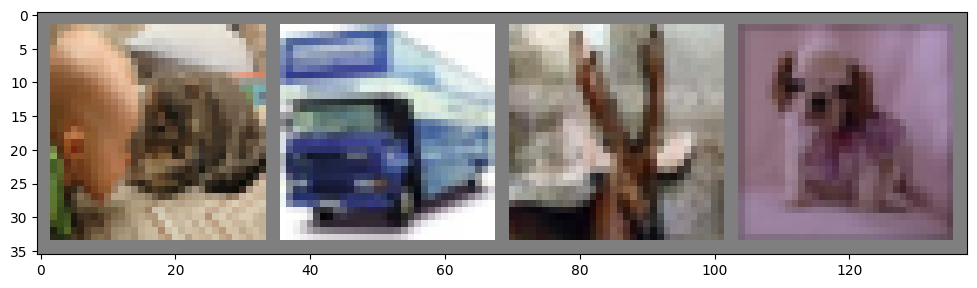

In [42]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print("Image shape: ", images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

### Construct a CNN in PyTorch

In the following class, initiate your different layers in the `__init__` method and define your architecture in the `forward` method. Make sure the `forward` method has a single return value. 

1. Make good use of the documentation and experiment will different layers, activations and architectures, batch sizes, regularization, filter sizes, dimensions, number of layers and whatever you learned in class. 
2. Use your intuition from the previous exercises and additional sources such as the stackoverflow, Medium, etc. - **do not try to perform a massive grid search.**
3. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
4. It is not allowed to use famous models that have been already implemented by PyTorch (resnet, densenet, alexnet, etc).
5. Make sure your code runs reasonably fast (no more than 15 minutes on CPU).
6. Use the best architecture you find and train it for 1-10 epochs. 
7. Visualize the loss and accuracy of your network during training. You can use matplotlib.
8. You should get above 60% accuracy on the test set.
**(20 points)**

In [58]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Initiate the different layers you wish to use in your network.            #
        # This method has no return value.                                          #
        #############################################################################

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.norm = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(4096, 64)
        self.fc2 = nn.Linear(64, 10)

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def forward(self, x):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and obtain class predictions.                                     #
        # This function returns the predication of your model.                      #
        #############################################################################

        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.norm(x)
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)

        return x

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

net = Net()
criterion = None
optimizer = None
#############################################################################
# TO DO:                                                                    #
# Define the loss function and optimizer.                                   #
#############################################################################

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [59]:
#############################################################################
# TO DO:                                                                    #
# Define the training loop as seen in class and as demonstrated in the      #
# documentation. Note, if you are using GPU, make sure your code runs on    #
# CPU also. Code that cannot run will not be tested.                        # 
#############################################################################

for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

[1,   782] loss: 0.548
[2,   782] loss: 0.390
[3,   782] loss: 0.330
[4,   782] loss: 0.291
[5,   782] loss: 0.259
[6,   782] loss: 0.230
[7,   782] loss: 0.205
[8,   782] loss: 0.182
[9,   782] loss: 0.160
[10,   782] loss: 0.139


## Model evaluation

Calculate the model accuracy and print a confusion matrix where in y axis represents the real category and the x axis represents the predicted category. **(10 points)** 

In [60]:
confusion_matrix = np.zeros([10,10], int)
model_accuracy = 0
#############################################################################
# TO DO:                                                                    #
# Define the evaluation loop as seen in class and as demonstrated in the    #
# documentation and use the confusion matrix to evaluate your model.        # 
#############################################################################

import pandas as pd
import seaborn as sn

shouldPrintHeatMap = False

for i, data in enumerate(testloader, 0):
    inputs, labels = data

    with torch.no_grad():
        outputs = net(inputs)

    y_pred = torch.argmax(outputs, dim = 1)

    for i in range(len(labels)):
        output_pred = y_pred[i]
        label = labels[i]
        confusion_matrix[label][output_pred] += 1

test_samples_count = np.sum(confusion_matrix)
model_accuracy = np.trace(confusion_matrix) / test_samples_count

if shouldPrintHeatMap:
    # Print confusion_matrix heatmap
    df_cm = pd.DataFrame(confusion_matrix / test_samples_count, index = [i for i in classes], columns = [i for i in classes])
    plt.figure(figsize = (12, 7))
    sn.heatmap(df_cm, annot=True)
    plt.show()

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
print('Model accuracy on {0} test images: {1:.2f}%'.format(len(testset), model_accuracy))

Model accuracy on 10000 test images: 0.72%


ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of ticklabels (2).

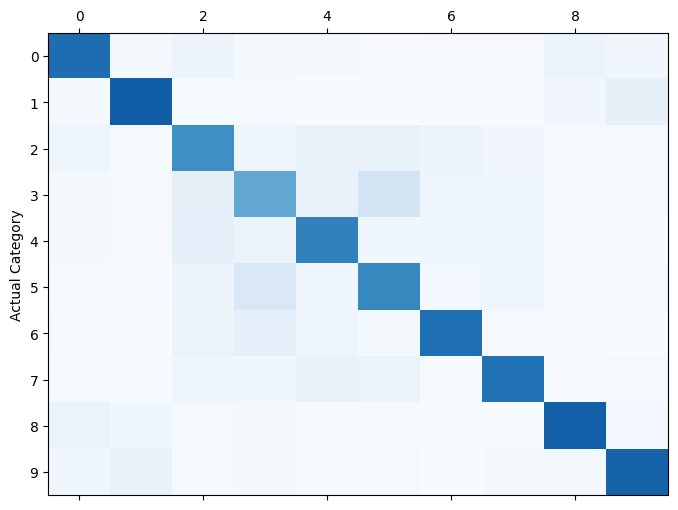

In [61]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

##**Question:** 
Describe your experiments.
What parameters have you experimented with? What works and what doesn't? Why?   **(5 Points)**

**Your answer:** *I tried to train the model with different depth of networks, and different kernel sizes. The experiment had only 10 epochs, so the model have to be simple, for satisfy results. At first, I tried shallow network with one convolution, one pooling and 2 fully connected layers, the best validation accuracy was under. When I tried to create deeper network with 2 convolution, pools and 2 fully connected layers the validation accuracy increased and is around 70%. At last, I have tried even deeper network that includes 4 convolution, pools and 3 fully connected layers, the training was too long, and the validation accuracy was lower than the model with the 2 convolution layers, I guess it cause because there are a lot of parameters to practice in this model and 10 epochs is not enough for this model. Then I tested the kernel size, in the experiment of kernel sizes, I tested 3 sizes of kernels 3, 5, 10. the best one was 3, and the worse was 10, for the kernel of size 10 the model does not converge, I guess the block size is too big to take in account small details*

##**Question:** 
What can you learn from the confusion matrix? Why do you need additional evaluation methods other than accuracy? **(5 Points)**

**Your answer:** *We can learn from the confusion matrix about the model precision of each class. Learn about the correlation between classes, and improve the model robustness. In additional by the confusing matrix we can learn about the data.
We need additional evaluation methods for learn more about the model and the data, the accuracy can be misleading.*

# Localization as Regression (60 points)

In the next part, we will use a well known architecture called ResNet18 that was trained on ImageNet, a dataset far more rich than CIFAR10. ImageNet has 1,000 classes and 1,000,000 images. In this part, we will use the features extracted from ResNet18 to localize and classify images of cats and dogs. 

Using a pretrained network as a building block for a more complicated task is at the heart of neural networks today. By leveraging the features ResNet18 extracts, we can train a model that can correctly classify and localize cats and dogs using very few images. 

In [47]:
import torchvision.transforms as transforms
from data.dataloader import *
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.models as models
import torch.nn as nn
from PIL import Image
import collections
import time
import copy
import sys
import os

To load ResNet18 with the pretrained weights, use the following line. You are welcome to try different architectures, however they might require different input sizes or normalization.

The first time you run this cell the weights will be downloaded.

In [48]:
resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

ResNet takes as input images of size (224,224). We will use PyTorch Transforms to change the size of the images. When ResNet18 was trained on ImageNet, the images were normalized using the mean and standard deviation of the images. In order to properly use the weights, we will use the same normalization.

In [49]:
data_transforms = {
    'train': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalizing according to imagenet
    ]),
    'val': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
root_dir = "data/animals/"
datasets = {x: VOCDetection(root_dir, image_set=x, transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
classes = datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)

{'train': 636, 'val': 158}


In [50]:
# Get a batch of training data
sample = next(iter(dataloaders['train']))

<Figure size 1200x800 with 0 Axes>

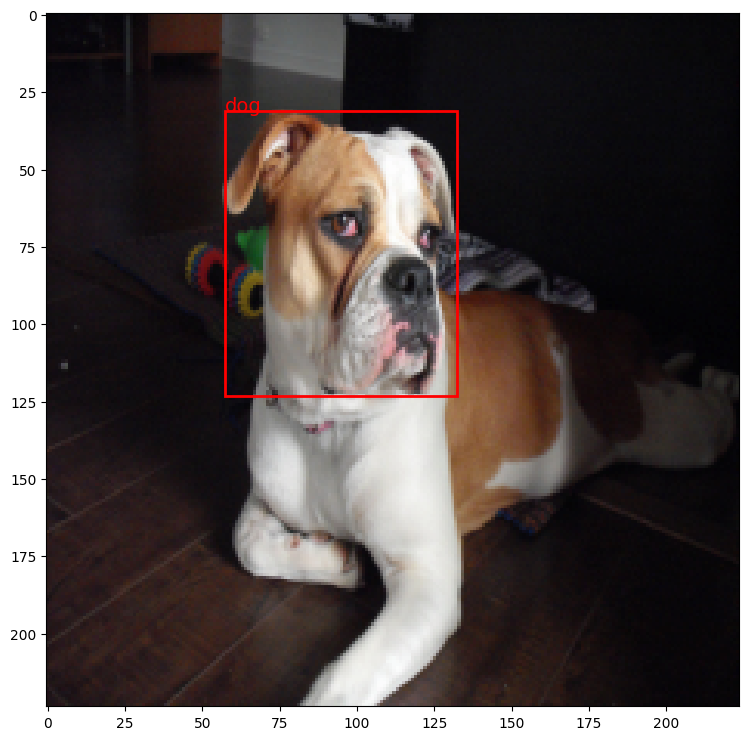

In [51]:
def imshow(img, label, bbox):
    image = np.copy(img[0])
    image = np.transpose(image, (1, 2, 0))
    image *= np.array([0.229, 0.224, 0.225])
    image += np.array([0.485, 0.456, 0.406])
    label = label[0]
    bbox = bbox[0]
    plt.figure();
    fig, ax = plt.subplots(1, figsize=(12,9));
    ax.imshow(image);
    x1, y1, x2, y2 = bbox.numpy().reshape(-1) * 224
    box_w, box_h = np.abs(x2-x1), np.abs(y2-y1)
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, 
                             edgecolor='r', facecolor='none');
    ax.add_patch(bbox);
    ax.annotate(classes[label], (x1, y1), color='r', fontsize=14);

imshow(sample['image'],sample['label'],sample['bbox'])

In [52]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Load the pretrained ResNet-18 network and replace the top fully connected #
        # layer, so we could use the features of the network and not the only      #
        # the classification layer which carries significantly less information.    #
        # Afterwards, create a new sequential model with the remaining layers of    #
        # the pretrained network. Next, define two additional models that take as   #
        # input the extracted features and output the class scores and bounding box #
        # coordinates.                                                              #
        # This function has no return value.                                        #
        #############################################################################

        self.resnet18_without_top_layer = torch.nn.Sequential(*(list(resnet18.children())[:-1]))
        for param in self.resnet18_without_top_layer.parameters():
            param.requires_grad = False

        self.resnet18_flatten_layer = nn.Flatten()

        # Classifier model
        self.classifier_fc_layer = nn.Linear(512, num_classes)
        for param in self.classifier_fc_layer.parameters():
            param.requires_grad = True

        # Bounding box model
        self.boundingBox_fc1_layer = nn.Linear(512, 64)
        self.boundingBox_fc2_layer = nn.Linear(64, 4)
        for param in self.boundingBox_fc1_layer.parameters():
            param.requires_grad = True
        for param in self.boundingBox_fc2_layer.parameters():
            param.requires_grad = True

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
    
    def forward(self, images):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and extract the feature vector. In this case, when using a        #
        # predefined network, you don't want to change it's weights.                #
        # The rest of the layers you defined should accepts gradients for them to   #
        # improve during training.                                                  #
        # This function returns a class predication and a bounding box coordinates. #
        #############################################################################

        resnet_output = self.resnet18_without_top_layer(images)
        resnet_output = self.resnet18_flatten_layer(resnet_output)

        # Classifier model
        scores = self.classifier_fc_layer(resnet_output)

        # Boarding box model
        boundingBoxes = nn.functional.relu(self.boundingBox_fc1_layer(resnet_output))
        boundingBoxes = self.boundingBox_fc2_layer(boundingBoxes)

        return scores, boundingBoxes

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

## Guidelines

1. Complete the `train_model` function in the cell below. This function takes as input the model and additional hyper-parameters, and outputs the best model found on the validation set. 
2. To babysit the learning process, **you must track the classification accuracy, IoU score and loss on the training and validation datasets and visualize them** (using matplotlib or similar). I have included an implementation of the IoU metric in the file `data\dataloader.py`.
3. Do not perform a massive grid search. Use papers, blogs, MOOCs and online guides to research best hyper-parameters for your model.
4. You are encouraged to try Google Colab. If you have an CUDA capable GPU at home - you are welcome to use it.
5. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
6. Training large neural networks may take a while. Make sure your code runs reasonably fast (~15 minutes on CPU and ~5 minutes on GPU).
7. Try to reach at least 90% classification accuracy and a IOU score of at least 0.60 on the validation set.
8. **In order to get full marks for this section explain the results and include visualizations.**.
9. You are given a general skeleton for the training function. Feel free to use any different structure.

In [53]:
def train_model(model, criterion_cls, criterion_bbox, optimizer, scheduler=None, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict()) # this is how a model is copied
    best_acc = 0.0
    history = { "train": { "losses": [], "accuracies": [], "ious": [] }, "val": { "losses":[], "accuracies": [], "ious": [] }}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0   # total loss of the network at each epoch
            running_corrects = 0 # number of correct predictions
            iou = 0.0            # IoU score
            
            # Iterate over data.
            for sample in dataloaders[phase]:
                #############################################################################
                # TO DO:                                                                    #
                # Extract the data from the dataloader, calculate the predictions of your   #
                # network and calculate the loss of the classification and bounding box     #
                # prediction. When in training mode, back-prop and update the weights.      #
                # At each epoch, calculate the test and train accuracy and IoU.             #
                # This function returns the best model in terms of accuracy.                #
                #############################################################################

                # get the inputs; data is a list of [inputs, labels]
                inputs, labels, bboxs = sample['image'], sample['label'], sample['bbox']

                # zero the parameter gradients
                optimizer.zero_grad()

                if phase == 'train':
                    # forward + backward + optimize
                    model.train()
                    scores, boundingBoxes = model.forward(inputs)

                    loss_cls = criterion_cls(scores, labels)
                    loss_cls.backward(retain_graph=True)

                    loss_bbox = criterion_bbox(boundingBoxes, bboxs)
                    loss_bbox.backward(retain_graph=True)

                    running_loss += 0.5 * (loss_cls.item() + loss_bbox.item())

                    optimizer.step()
                else:
                    model.eval()
                    scores, boundingBoxes = model.forward(inputs)

                    loss_cls = criterion_cls(scores, labels)
                    running_loss += loss_cls.item()

                    loss_bbox = criterion_bbox(boundingBoxes, bboxs)
                    running_loss += loss_bbox.item()

                y_preds = torch.argmax(scores, dim = 1)

                running_corrects += (y_preds == labels).sum()
                for i in range(bboxs.shape[0]):
                    iou += bb_intersection_over_union(bboxs[i], boundingBoxes[i])

                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            iou = iou.item() / dataset_sizes[phase]

            history[phase]["losses"].append(epoch_loss)
            history[phase]["accuracies"].append(epoch_acc)
            history[phase]["ious"].append(iou)

            print('{} Loss: {:.4f}  |  Acc: {:.4f}  |  IOU: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, iou))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

Choose your optimizer and the loss functions for the classification and bounding box regression.

In [54]:
import torch.optim as optim

cnn = CNN(2)
cnn = cnn.to(device)

criterion_cls = None
criterion_bbox = None
optimizer = None
#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################

criterion_cls = nn.CrossEntropyLoss()
criterion_bbox = nn.MSELoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [55]:
best_model, history = train_model(cnn, criterion_cls, criterion_bbox, optimizer, num_epochs=10)

Epoch 1/10
----------
train Loss: 0.0092  |  Acc: 0.7421  |  IOU: 0.6068
val Loss: 0.0086  |  Acc: 0.9430  |  IOU: 0.6974
Epoch 2/10
----------
train Loss: 0.0038  |  Acc: 0.9308  |  IOU: 0.7104
val Loss: 0.0047  |  Acc: 0.9873  |  IOU: 0.7163
Epoch 3/10
----------
train Loss: 0.0023  |  Acc: 0.9733  |  IOU: 0.7300
val Loss: 0.0035  |  Acc: 0.9873  |  IOU: 0.7252
Epoch 4/10
----------
train Loss: 0.0021  |  Acc: 0.9733  |  IOU: 0.7422
val Loss: 0.0032  |  Acc: 0.9810  |  IOU: 0.7393
Epoch 5/10
----------
train Loss: 0.0017  |  Acc: 0.9843  |  IOU: 0.7509
val Loss: 0.0026  |  Acc: 0.9937  |  IOU: 0.7438
Epoch 6/10
----------
train Loss: 0.0016  |  Acc: 0.9748  |  IOU: 0.7591
val Loss: 0.0025  |  Acc: 0.9873  |  IOU: 0.7422
Epoch 7/10
----------
train Loss: 0.0013  |  Acc: 0.9921  |  IOU: 0.7609
val Loss: 0.0022  |  Acc: 0.9873  |  IOU: 0.7509
Epoch 8/10
----------
train Loss: 0.0015  |  Acc: 0.9796  |  IOU: 0.7660
val Loss: 0.0021  |  Acc: 0.9873  |  IOU: 0.7466
Epoch 9/10
----------
tr

Once you are pleased with your results, see how your model can predict and localize cats and dogs!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1200x800 with 0 Axes>

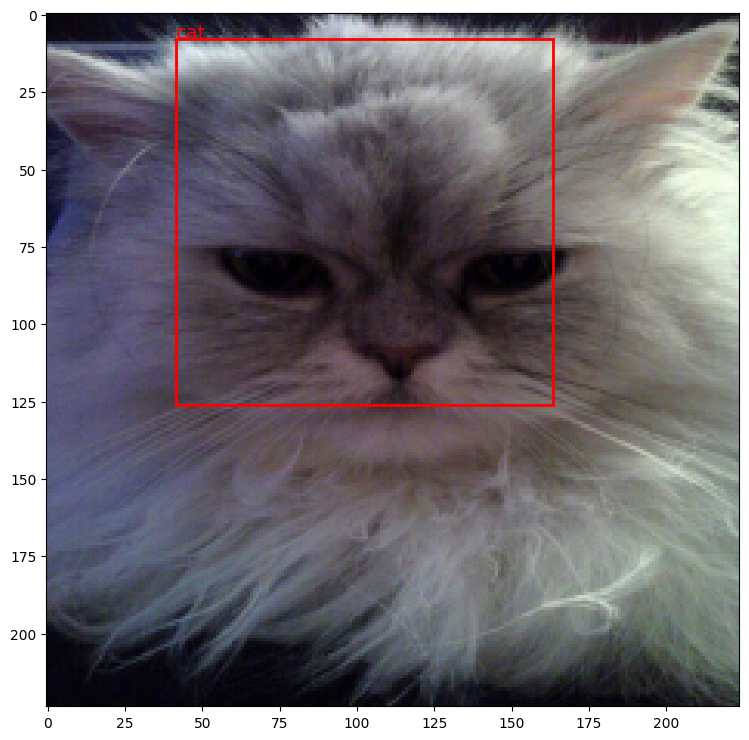

In [56]:
# Get a batch of validation data
sample = next(iter(dataloaders['val']))
with torch.no_grad():
    images = sample['image']
    images = images.to(device)
    label_pred, bbox_pred = best_model(images)
    _, label_pred = torch.max(label_pred, 1)
imshow(sample['image'], label_pred.cpu(), bbox_pred.cpu())

Your visualizations here (IoU / Accuracy / Loss on training and validation datasets as a function of the epoch). Only visualize the results of your best model.

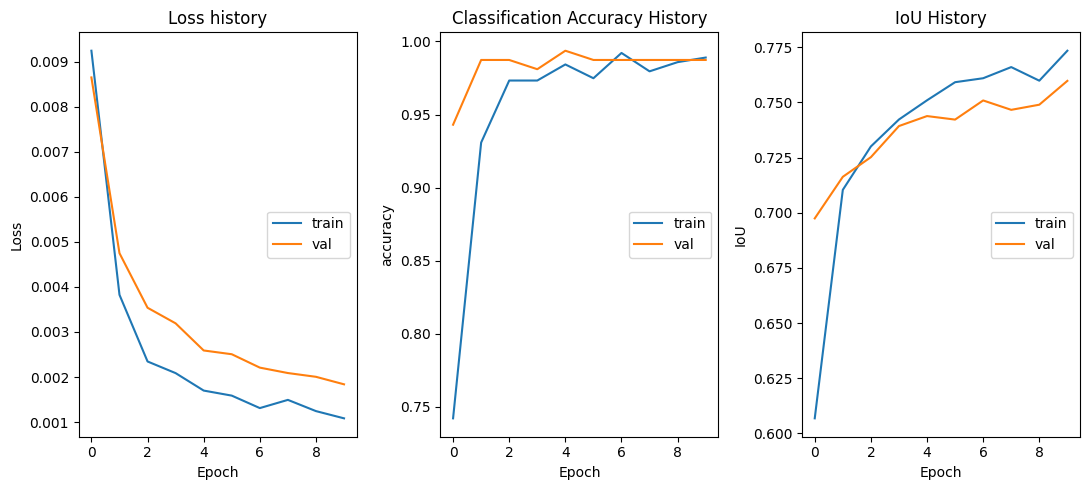

In [65]:
fig, (loss_plot, accuracy_plot, iou_plot)= plt.subplots(1, 3, figsize=(20, 5), tight_layout=True)

loss_plot.plot(history["train"]["losses"], label='train')
loss_plot.plot(history["val"]["losses"], label='val')
loss_plot.set_title('Loss history')
loss_plot.set_xlabel('Epoch')
loss_plot.set_ylabel('Loss')
loss_plot.legend(loc='right')

accuracy_plot.plot(history["train"]["accuracies"], label='train')
accuracy_plot.plot(history["val"]["accuracies"], label='val')
accuracy_plot.set_title('Classification Accuracy History')
accuracy_plot.set_xlabel('Epoch')
accuracy_plot.set_ylabel('accuracy')
accuracy_plot.legend(loc='right')

iou_plot.plot(history["train"]["ious"], label='train')
iou_plot.plot(history["val"]["ious"], label='val')
iou_plot.set_title('IoU History')
iou_plot.set_xlabel('Epoch')
iou_plot.set_ylabel('IoU')
iou_plot.legend(loc='right')

plt.show()